<a href="https://colab.research.google.com/github/ChelseaOwiti/Colposcopy-Scan/blob/main/draft5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Project
%ls

/content/drive/MyDrive/Project
assets/       draft1_model.h5           keras_metadata.pb  saved_model.pb
d2_model.h5   draft2.ipynb              logs/              variables/
d3_model.h5   h5_model.h5               model.tflite
data/         imagenet_draft3_model.h5  output/
draft1.ipynb  imagenet_model.h5         resnet50_model.h5


In [2]:
trainpath = 'data/train'
valpath = 'data/val'
testpath = 'data/test'

In [3]:
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import pathlib

In [4]:
train_dir = pathlib.Path(trainpath)
test_dir = pathlib.Path(valpath)

print(str(len(list(train_dir.glob('*/*.jpg'))) )+ ' Training Images')
print(str(len(list(test_dir.glob('*/*.jpg')))) + ' Testing Images')

888 Training Images
296 Testing Images


In [6]:
batch_size = 32  
img_height = 280
img_width = 280

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 800 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 88 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Type_1', 'Type_2', 'Type_3']


In [10]:
for image_batch, labels_batch in train_ds: #image batch is a tensor of the shape
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 280, 280, 3)
(32,)


In [11]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

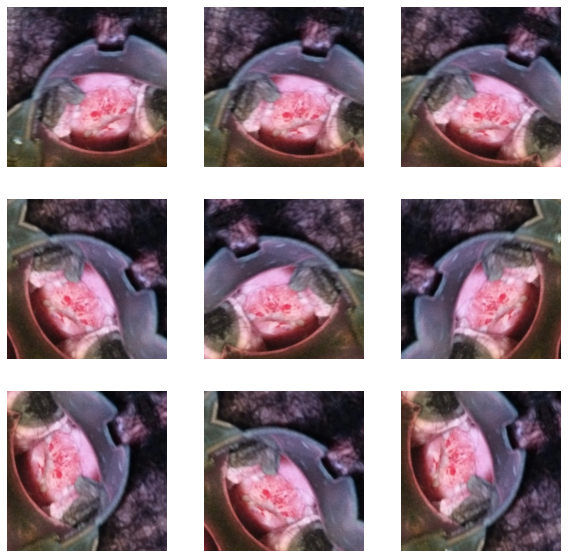

In [15]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [16]:
IMG_SIZE = (280, 280)

In [19]:
num_classes = len(class_names)
resnet152_model = Sequential()

pretrained_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(280, 280, 3),
    pooling='avg',
    classes=num_classes,
)

In [20]:
for layer in pretrained_model.layers:
        layer.trainable=False

resnet152_model.add(pretrained_model)

In [21]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [22]:
resnet152_model.add(Flatten())
resnet152_model.add(Dense(512, activation='relu'))
resnet152_model.add(Dense(5, activation='softmax'))

In [23]:
resnet152_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 59,422,597
Trainable params: 1,051,653
Non-trainable params: 58,370,944
_________________________________________________________________


In [24]:
resnet152_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [25]:
epochs = 10
history = resnet152_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs)
     

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 48s 1s/step - loss: 1.5284 - accuracy: 0.4475 - val_loss: 1.0226 - val_accuracy: 0.4432
Epoch 2/10
25/25 [==============================] - 11s 450ms/step - loss: 0.8244 - accuracy: 0.6125 - val_loss: 1.0184 - val_accuracy: 0.4659
Epoch 3/10
25/25 [==============================] - 11s 458ms/step - loss: 0.7326 - accuracy: 0.6675 - val_loss: 1.2762 - val_accuracy: 0.3295
Epoch 4/10
25/25 [==============================] - 12s 470ms/step - loss: 0.6439 - accuracy: 0.7237 - val_loss: 1.0270 - val_accuracy: 0.4773
Epoch 5/10
25/25 [==============================] - 12s 464ms/step - loss: 0.5815 - accuracy: 0.7588 - val_loss: 1.1123 - val_accuracy: 0.5000
Epoch 6/10
25/25 [==============================] - 11s 457ms/step - loss: 0.5184 - accuracy: 0.7950 - val_loss: 1.2993 - val_accuracy: 0.5227
Epoch 7/10
25/25 [==============================] - 12s 468ms/step - loss: 0.4792 - accuracy: 0.8213 - val_loss: 1.2653 - val_accuracy: 0.4886
Epoch 8/10
25

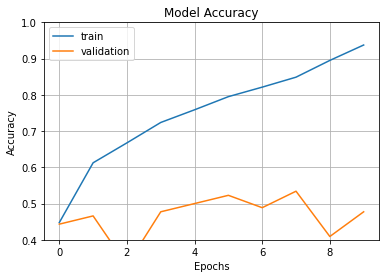

In [26]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

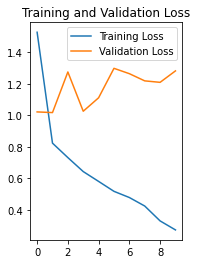

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
test_image = '/content/drive/MyDrive/Project/data/train/Type_1/1013.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet152_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
     

1/1 [==============================] - 3s 3s/step
This image most likely belongs to Type_1 with a 39.96 percent confidence.


In [31]:
#Type 2
test_image = '/content/drive/MyDrive/Project/data/val/Type_2/1140.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet152_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to Type_2 with a 37.96 percent confidence.


In [30]:
test_image = '/content/drive/MyDrive/Project/data/val/Type_3/1029.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet152_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to Type_3 with a 31.48 percent confidence.


In [32]:
resnet152_model.save("resnet152_model.h5")